# Simple classification with pytorch

## Data processing

### Create a csv file 

In [1]:
import os 
os.chdir('/home/aurelien/Desktop/pytorch-sea-animals/')
import yaml
from src.data.filter_classes import make_csv_path

# Read params
params = yaml.safe_load(open('params.yaml'))
excluded_classes = params['prepare']['excluded_classes']

make_csv_path(excluded_labels=excluded_classes)

(11696, 2)
Csv file constituted with 9927 images, representing 16 classes, excluding Crabs, Corals, Dolphin


### Get the mean and std for image standardization

In [3]:
# Modules
import torch
import torchvision.transforms as T
from src.data.CustomImageDataset import CustomImageDataset
from src.data.get_img_mean_std import get_mean_and_std

image_size = params['prepare']['image_size']

transformf = T.Compose(
    [T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor()])

dataset = CustomImageDataset(annotations_file='./data/interim/filepath.csv', transform=transformf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)

mean, std = get_mean_and_std(dataloader)

dict_mean_std = {'mean': mean.tolist(), 'std': std.tolist()}

with open("./data/processed/image_mean_std.yaml", "w") as outfile:
    yaml.dump(dict_mean_std, outfile)

### Plot some images for verification

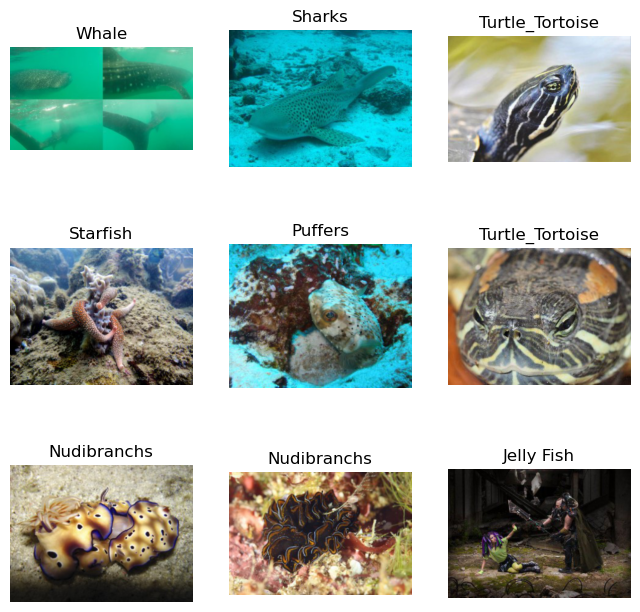

In [8]:
# Modules
import torch
import matplotlib.pyplot as plt 

# Scripts
label_map = yaml.safe_load(open('./data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation
 

In [8]:
# Modules
from src.data.split_dataset import split_dataset

split_dataset(
        annotations_file='./data/interim/filepath.csv',
        output_folder='./data/processed',
        test_split=params['prepare']['test_split'],
        val_split=params['prepare']['val_split'],
        random_seed=99)

Train set shape: (6352, 3) 
 Val set shape: (1589, 3) 
 Test set shape: (1986, 3)


Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


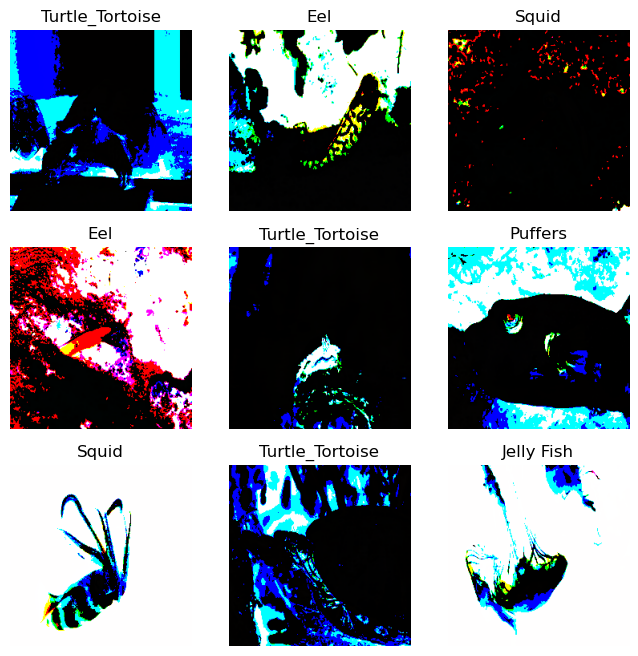

In [15]:
# Modules
import yaml
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Dependencies
mean_std = yaml.safe_load(open('./data/processed/image_mean_std.yaml'))

# Parameters
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
image_size = (227,227)

# Scripts 
train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

train_dataset = CustomImageDataset(annotations_file='./data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_T=T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

val_dataset = CustomImageDataset(annotations_file='./data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomImageDataset(annotations_file='./data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_map = yaml.safe_load(open('./data/processed/labels_map.yaml'))

denorm = T.Normalize(
    mean=[-m / s for m, s in zip(mean_std['mean'], mean_std['std'])],
    std=[1.0 / s for s in mean_std['std']])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
plt.show()


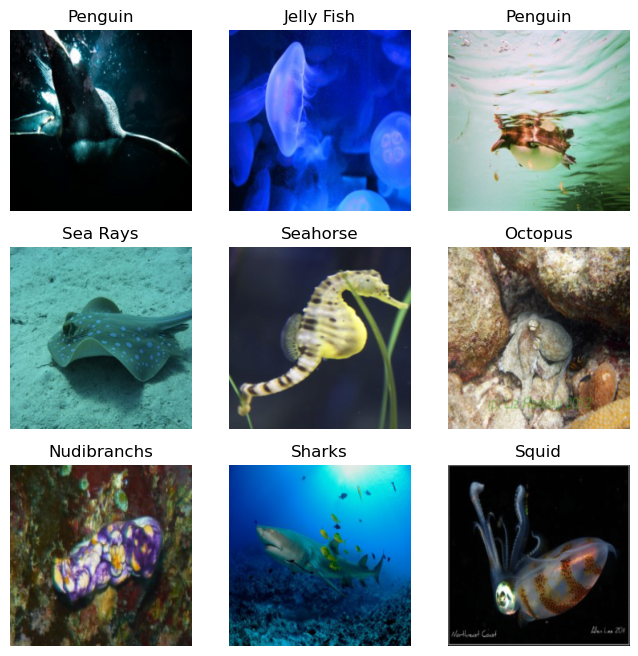

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(denorm(img).permute(1, 2, 0))
plt.show()

## Training the network

To do: 
- Define early stopping 
- Register parameters early stopping with mlflow


In [16]:
import torchvision
from torch import nn
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.optim import Adam

# Define the LightningModule

class mobilenetv3_fe(pl.LightningModule):

    def __init__(self, n_classes, learning_rate):
        super().__init__()

        # Parameters
        self.lr = learning_rate
        self.num_classes = n_classes

        # Init a pretrained mobilenetv3 model
        
        self.model = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1', pretrained=True, progress=True)
        
        # Feature extraction : freeze the network
        for param in self.model.parameters():
                param.requires_grad = False
        
        # Replacing last layer with new layer (not frozen)
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[3] = nn.Linear(num_ftrs, self.num_classes)


    def forward(self, x):
        out = self.model(x)
        return out
    
    def loss_fn(self, out, target):
        return nn.CrossEntropyLoss()(out.view(-1, self.num_classes), target)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)

        logits = nn.Softmax(-1)(out) 
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, label, task='multiclass', num_classes=self.num_classes)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)
        logits = nn.Softmax(-1)(out) 
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, label, task='multiclass', num_classes=self.num_classes)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
        
    def validation_step(self,batch,batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        out = nn.Softmax(-1)(out) 
        return torch.argmax(out,dim=1)


class LightDataset(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size

        self.train_T=T.Compose([
            T.AutoAugment(policies[0]),
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

        self.val_T=T.Compose([
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

    def train_dataloader(self):
        train_dataset = CustomImageDataset(annotations_file='./data/processed/train.csv', transform=self.train_T)
        train_loader = DataLoader(train_dataset,
                            batch_size=self.batch_size,
                            shuffle=True, num_workers=8)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = CustomImageDataset(annotations_file='./data/processed/val.csv', transform=self.val_T)
        valid_loader = DataLoader(val_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return valid_loader
    
    def test_dataloader(self):
        test_dataset = CustomImageDataset(annotations_file='./data/processed/test.csv', transform=self.val_T)
        test_loader = DataLoader(test_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return test_loader

In [17]:
import mlflow.pytorch
from mlflow import MlflowClient
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

mlflow.set_tracking_uri("../mlruns")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

# Callbacks

early_stop_callback = EarlyStopping(monitor="val_acc",
 min_delta=0.00, patience=3, verbose=False, mode="max")


# Initialize a trainer
trainer = pl.Trainer(accelerator='gpu', devices=-1,
 max_epochs=1, callbacks=[early_stop_callback])

BATCH_SIZE = 6
LR = 0.001
num_classes = len(label_map)


# Auto log all MLflow entities
mlflow.pytorch.autolog()

with mlflow.start_run() as run:

    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("batch_size", BATCH_SIZE)
    
    model = mobilenetv3_fe(learning_rate=LR, n_classes=num_classes)
    dx = LightDataset(batch_size=BATCH_SIZE)

    trainer.fit(model, dx)
    trainer.test(model, dx)

# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

Current tracking uri: ../mlruns


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | MobileNetV3 | 1.5 M 
--------------------------------------
16.4 K    Trainable params
1.5 M     Non-trainable params
1.5 M     Total params
6.137     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1324/1324 [00:23<00:00, 57.34it/s, loss=1.34, v_num=1, train_loss=2.130, train_acc=0.250, val_loss=0.887, val_acc=0.728]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1324/1324 [00:23<00:00, 57.26it/s, loss=1.34, v_num=1, train_loss=2.130, train_acc=0.250, val_loss=0.887, val_acc=0.728]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 331/331 [00:03<00:00, 93.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7150050401687622     │
│         test_loss         │    0.9274339079856873     │
└───────────────────────────┴───────────────────────────┘

run_id: 052948adc6ac41718f0411c6d190978d
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'maximize': 'False', 'lr': '0.001', 'num_classes': '16', 'differentiable': 'False', 'monitor': 'val_acc', 'betas': '(0.9, 0.999)', 'batch_size': '6', 'min_delta': '0.0', 'optimizer_name': 'Adam', 'capturable': 'False', 'epochs': '1', 'foreach': 'None', 'weight_decay': '0', 'amsgrad': 'False', 'stopped_epoch': '0', 'fused': 'False', 'patience': '3', 'eps': '1e-08', 'mode': 'max'}
metrics: {'train_acc': 0.25, 'train_loss': 2.130110740661621, 'test_loss': 0.9274339079856873, 'val_acc': 0.7275015711784363, 'test_acc': 0.7150050401687622, 'val_loss': 0.887063205242157}
tags: {'Mode': 'testing'}


## Predict and evaluate on test set

In [18]:
from sklearn.metrics import classification_report

test_dataloader = LightDataset(batch_size=1).test_dataloader()
pred = trainer.predict(model, test_dataloader)
y_pred = list(map(lambda x: x.item(), pred))

y_true = []
for test_data in test_dataloader:
    y_true.append(test_data[1].item())


print(classification_report(y_true, y_pred, digits=4, target_names=label_map.values()))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1986/1986 [00:15<00:00, 125.52it/s]
                 precision    recall  f1-score   support

            Eel     0.4886    0.4343    0.4599        99
     Jelly Fish     0.8061    0.9240    0.8610       171
        Lobster     0.7579    0.7200    0.7385       100
    Nudibranchs     0.5952    0.7500    0.6637       100
        Octopus     0.4615    0.3214    0.3789       112
        Penguin     0.8118    0.7188    0.7624        96
        Puffers     0.5280    0.6226    0.5714       106
       Sea Rays     0.6133    0.4466    0.5169       103
    Sea Urchins     0.8779    0.9914    0.9312       116
       Seahorse     0.8154    0.5579    0.6625        95
           Seal     0.6860    0.7195    0.7024        82
         Sharks     0.4855    0.7119    0.5773       118
          Squid     0.8364    0.4792    0.6093        96
       Starfish     0.7983    0.9596    0.8716        99
Turtle_Tortoise     0.8833    0.8786    0.8810       379
         